In [1]:
import pandas as pd
import pm4py
import matplotlib.pyplot as plt
from typing import Optional, Set, FrozenSet
import numpy as np
import networkx as nx
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.objects.process_tree.obj import ProcessTree, Operator

In [2]:
XES_PATH = r"BPI2017Denied(3).xes"

In [ ]:
if __name__ == "__main__":
    event_log = pm4py.read_xes(XES_PATH)
    net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(event_log)
    pm4py.view_petri_net(net, im, fm)
    fitness = pm4py.fitness_token_based_replay(event_log, net, initial_marking, final_marking)
    prec = pm4py.precision_token_based_replay(event_log, net, initial_marking, final_marking)
    gen = generalization_evaluator.apply(event_log, net, initial_marking, final_marking)
    simplicity = simplicity_evaluator.apply(net)
    print(f"Fitness: {fitness['averageFitness']}")
    print(f"Precision: {prec}")
    print(f"Generalization: {gen}")
    print(f"Simplicity: {simplicity}") 

c:\Users\ramae\OneDrive\Documents\Uni\Master Jaar 2\Process Mining\Git\ProcessMining\.venv\Lib\site-packages\pm4py\utils.py:964: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")
c:\Users\ramae\OneDrive\Documents\Uni\Master Jaar 2\Process Mining\Git\ProcessMining\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 3093/3093 [00:14<00:00, 215.68it/s]


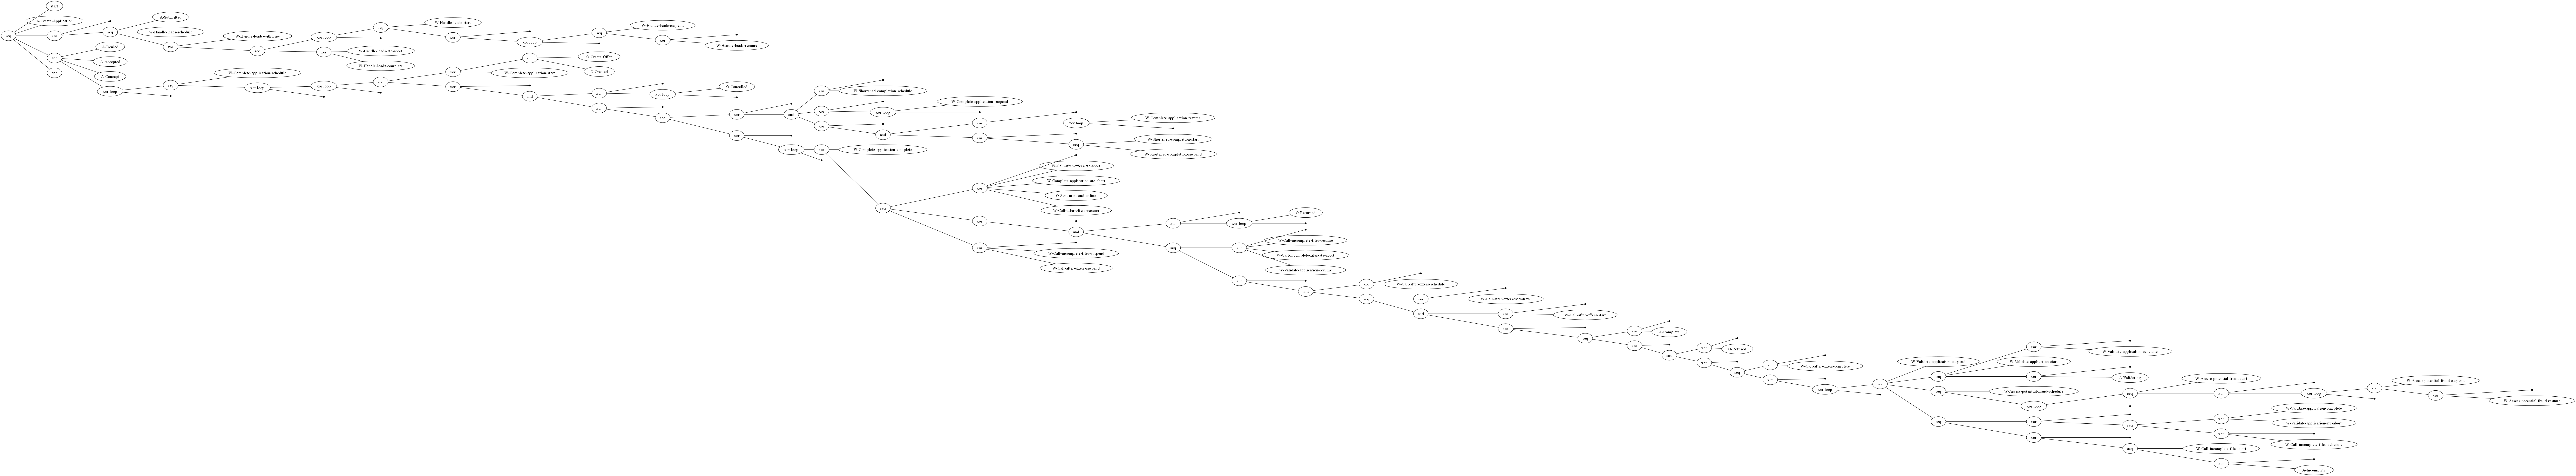

In [8]:
if __name__ == "__main__":
    event_log = pm4py.read_xes(XES_PATH)
    tree = pm4py.discover_process_tree_inductive(event_log)
    pm4py.view_process_tree(tree)

In [9]:
def get_leaf_activities(node):
    if node.label is not None:  # leaf activity
        return {node.label}
    acts = set()
    for child in node.children:
        acts |= get_leaf_activities(child)
    return acts

def extract_parallel_pairs(node):
    pairs = set()
    if node.operator == Operator.PARALLEL:
        children_sets = [get_leaf_activities(c) for c in node.children]
        for i in range(len(children_sets)):
            for j in range(i+1, len(children_sets)):
                for a in children_sets[i]:
                    for b in children_sets[j]:
                        pairs.add(frozenset([a, b]))
    for child in node.children:
        pairs |= extract_parallel_pairs(child)
    return pairs

parallel_pairs = extract_parallel_pairs(tree)
print("Detected parallel pairs:", parallel_pairs)

Detected parallel pairs: {frozenset({'A-Concept', 'W-Call-incomplete-files-resume'}), frozenset({'A-Accepted', 'O-Created'}), frozenset({'A-Accepted', 'O-Sent-mail-and-online'}), frozenset({'W-Validate-application-schedule', 'W-Call-after-offers-schedule'}), frozenset({'W-Call-after-offers-schedule', 'W-Call-incomplete-files-start'}), frozenset({'W-Shortened-completion-schedule', 'W-Shortened-completion-start'}), frozenset({'A-Concept', 'W-Call-after-offers-withdraw'}), frozenset({'A-Denied', 'W-Assess-potential-fraud-schedule'}), frozenset({'W-Validate-application-schedule', 'A-Concept'}), frozenset({'A-Concept', 'W-Call-incomplete-files-start'}), frozenset({'W-Shortened-completion-start', 'O-Cancelled'}), frozenset({'O-Returned', 'A-Complete'}), frozenset({'W-Validate-application-start', 'O-Returned'}), frozenset({'W-Validate-application-ate-abort', 'O-Returned'}), frozenset({'W-Call-after-offers-schedule', 'W-Assess-potential-fraud-start'}), frozenset({'W-Call-after-offers-schedule'

In [10]:
# Define ParallelPairs as a type alias for better readability
ParallelPairs = Set[FrozenSet[str]]

def compute_handover_matrix(
    log_df: pd.DataFrame,
    case_col: str = "case_id",
    activity_col: str = "activity",
    resource_col: str = "resource",
    timestamp_col: Optional[str] = None,
    parallel_pairs: Optional[ParallelPairs] = None,
) -> pd.DataFrame:
    """
    Compute mean number of handovers (from resource r1 to r2) per case.

    Parameters
    ----------
    log_df : pandas.DataFrame
        Event log: one row per event.
    case_col, activity_col, resource_col : str
        Column names
    timestamp_col : str or None
        If provided, rows PER CASE are sorted by this column. If None, it assumes
        the rows are already ordered in case order.
    parallel_pairs : set of frozensets or None
        Set containing unordered pairs of activities that are parallel.
        If None, no activity is considered parallel.

    Returns
    -------
    handover_df : pandas.DataFrame
        DataFrame indexed / columns by resource names, with values = mean handovers per case.
    """

    if parallel_pairs is None:
        parallel_pairs = set()

    # distinct resources
    resources = sorted(log_df[resource_col].dropna().unique().tolist())
    r_index = {r: i for i, r in enumerate(resources)}
    n = len(resources)

    # total handover counts across all cases (directed)
    total_counts = np.zeros((n, n), dtype=float)

    # number of cases (denominator)
    cases = log_df[case_col].unique()
    n_cases = len(cases)
    if n_cases == 0:
        raise ValueError("Empty log or no cases found.")

    # group by case
    grouped = log_df.groupby(case_col)

    for case_id, group in grouped:
        # ensure events in this case are ordered
        if timestamp_col is not None:
            group_sorted = group.sort_values(timestamp_col, kind="mergesort")
        else:
            # preserve original order within group
            group_sorted = group

        # iterate consecutive pairs
        events = group_sorted[[activity_col, resource_col]].values
        # events is list of rows [activity, resource]
        for i in range(len(events) - 1):
            act_i, res_i = events[i]
            act_j, res_j = events[i + 1]

            # skip missing resources or activities
            if pd.isna(res_i) or pd.isna(res_j) or pd.isna(act_i) or pd.isna(act_j):
                continue

            # same resource -> not a handover
            if res_i == res_j:
                continue

            # skip if activities are model-declared parallel
            if frozenset([act_i, act_j]) in parallel_pairs:
                continue

            # otherwise increment handover count res_i -> res_j
            if res_i in r_index and res_j in r_index:
                total_counts[r_index[res_i], r_index[res_j]] += 1.0
    print(total_counts)
    # mean per case
    mean_per_case = total_counts / np.array(total_counts).sum()

    handover_df = pd.DataFrame(mean_per_case, index=resources, columns=resources)
    return handover_df, total_counts




In [11]:
handover_df, total_counts = compute_handover_matrix(
    log_df= pm4py.read_xes(XES_PATH),                 
    case_col="case:concept:name",
    activity_col="concept:name",
    resource_col="org:resource",
    timestamp_col="time:timestamp",
    parallel_pairs=parallel_pairs
)
#handover_df.to_csv('outputs_task_similarity_nb/handover_matrix.csv', )

parsing log, completed traces :: 100%|██████████| 3093/3093 [00:09<00:00, 318.41it/s]


[[ 0. 10.  0. ...  0.  0.  2.]
 [ 2.  0.  0. ...  0.  0.  0.]
 [ 2.  1.  0. ...  0.  0.  1.]
 ...
 [ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]]


In [16]:
np.amax(np.array(total_counts), axis=1)

array([ 83.,  10.,  21.,   4.,  18.,   4.,  20.,   6.,   1.,   4.,   6.,
         1.,  61.,  68.,  23.,   3.,  74.,  86.,  74.,  42.,   5.,  26.,
        59.,  23.,  33.,   1.,  18.,  22.,  10.,   1.,   2.,   7.,   3.,
        11.,  11.,  11.,   1.,   1.,   5.,   1.,  12.,   0.,   2.,   0.,
         8.,  18.,  18.,  15.,  10.,  19.,  13.,  25.,   6.,   5.,   2.,
         8.,  12.,   3.,  11.,  25.,  17.,   8.,  34.,  53.,  20.,  13.,
         8.,   7.,   7.,   8.,  13.,   6.,  11.,   8.,  20.,  15.,  10.,
         8.,   4.,  16.,  11.,   5.,  11.,  15.,  41.,   1.,  11.,   8.,
         5.,   8.,   8.,   3.,   7.,   6.,   4.,   1.,  11.,  10.,   5.,
         6.,   1.,   3.,   3.,   7.,  34.,   0.,   8.,   5.,   7.,   4.,
         5.,  12.,   2.,   6.,   5.,   5.,   2.,   1.,   1.,   9.,   2.,
        10.,   3., 105.,   1.,   3.,  15.,   2.,   3.,  30.,  14.,   5.,
         2.,  11.])

In [17]:
def handover_network_from_matrix(
    handover_df: pd.DataFrame,
    threshold: float = 0.0,
    directed: bool = True,
    show_unconnected_nodes: bool = False
) -> nx.Graph | nx.DiGraph:
    """
    Create a NetworkX graph from a handover DataFrame.
    Only edges with weight >= threshold are included.

    Parameters
    ----------
    handover_df : pandas.DataFrame
        index and columns are resource names; values are mean handovers per case
    threshold : float
        Minimum edge weight to keep
    directed : bool
        If False, returns an undirected graph (weight = mean of both directions)
    show_unconnected_nodes : bool
        If True, nodes without meaningful edges are included.

    Returns
    -------
    G : networkx.DiGraph or Graph
    """
    G = nx.DiGraph() if directed else nx.Graph()

    if directed:
        for src in handover_df.index:
            for dst in handover_df.columns:
                w = handover_df.at[src, dst]
                if w >= threshold and w > 0:
                    G.add_edge(src, dst, weight=float(w))
        if show_unconnected_nodes:
            for node in handover_df.index:
                G.add_node(node)
    else:
        visited = set()
        for a in handover_df.index:
            for b in handover_df.columns:
                if (a, b) in visited or (b, a) in visited:
                    continue
                w = (handover_df.at[a, b] + handover_df.at[b, a]) / 2.0
                if w >= threshold and w > 0:
                    G.add_edge(a, b, weight=float(w))
                visited.add((a, b))
        if show_unconnected_nodes:
            for node in handover_df.index:
                G.add_node(node)

    return G

In [18]:
# Visualize matrix (it is demand in assignment to visualize)
print(handover_df.round(3))

          User_1  User_10  User_100  User_101  User_102  User_104  User_106  \
User_1       0.0    0.001       0.0       0.0       0.0       0.0       0.0   
User_10      0.0    0.000       0.0       0.0       0.0       0.0       0.0   
User_100     0.0    0.000       0.0       0.0       0.0       0.0       0.0   
User_101     0.0    0.000       0.0       0.0       0.0       0.0       0.0   
User_102     0.0    0.000       0.0       0.0       0.0       0.0       0.0   
...          ...      ...       ...       ...       ...       ...       ...   
User_93      0.0    0.000       0.0       0.0       0.0       0.0       0.0   
User_95      0.0    0.000       0.0       0.0       0.0       0.0       0.0   
User_96      0.0    0.000       0.0       0.0       0.0       0.0       0.0   
User_97      0.0    0.000       0.0       0.0       0.0       0.0       0.0   
User_99      0.0    0.000       0.0       0.0       0.0       0.0       0.0   

          User_107  User_108  User_109  ...  User_8

In [20]:
# Get network with threshold 0.02 mean handovers per case
G = handover_network_from_matrix(handover_df, threshold=0.001, show_unconnected_nodes=False)

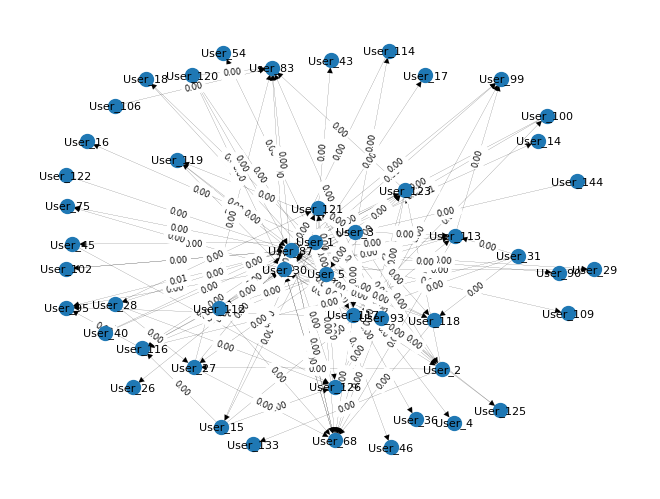

In [21]:
pos = nx.spring_layout(G, seed=42)
weights = [G[u][v]['weight'] for u,v in G.edges()]
nx.draw(G, pos, with_labels=True, node_size=100, width=[max(0.1, w*5) for w in weights], font_size=8)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()}, font_size=6)
plt.show()